# Contents

[Imports](#Imports)<br>
[Table_creation](#Table_creation)<br>
[Analysis](#Analysis)<br>
[Plots](#Plots)

# Imports

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_tags = pd.read_csv('../data/raw/ml-25m/tags.csv')
# df_gscores = pd.read_csv('../data/raw/ml-25m/genome-scores.csv')
# df_gtags = pd.read_csv('../data/raw/ml-25m/genome-tags.csv')
# df_links = pd.read_csv('../data/raw/ml-25m/links.csv')
#df_movies = pd.read_csv('../data/raw/ml-25m/movies.csv')
df_ratings = pd.read_csv('../data/raw/ml-25m/ratings.csv')

In [11]:
display(df_tags.head())
print(df_tags.info())
print('\nUnique values per column:')
print(df_tags.nunique())


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB
None

Unique values per column:
userId        14592
movieId       45251
tag           73050
timestamp    907730
dtype: int64


In [12]:
df_tags.drop(['timestamp'], axis=1).duplicated().sum()
# no movie is tagged with the same tag twice by same user

0

In [13]:
df_tags.drop(['tag','timestamp'], axis=1).duplicated().sum()
# it is common that users give different tags to single movies

788004

# Table_creation

In [14]:
tag_frequency = df_tags.drop(['userId','timestamp'], axis=1).groupby(by='tag').count().sort_values(by='movieId', ascending=False)
tag_frequency = tag_frequency.rename(columns={'movieId':'frequency'})
tag_frequency
# assumption: tags that only apply to one movie have no inherent value for prediction

,frequency
tag,
sci-fi,8330
atmospheric,6516
action,5907
comedy,5702
surreal,5326
...,...
author:Evan S. Connell,1
author:Fannie Hurst,1
author:Felix Salten,1


In [15]:
user_tagged_movies_sum = df_tags.drop(['tag','timestamp'], axis=1).drop_duplicates().groupby(by=['userId']).count()
user_tagged_movies_sum.rename(columns={'movieId':'n_movies'}, inplace=True)
user_tags_per_movie = df_tags.drop(['timestamp'], axis=1).groupby(by=['userId','movieId']).count()
user_tags_per_movie.rename(columns={'tag':'n_tags'}, inplace=True)
user_tags_dist = df_tags.drop(['timestamp'], axis=1).groupby(by=['userId','tag']).count()
user_tags_dist.rename(columns={'movieId':'n_movies'}, inplace=True)

display(user_tagged_movies_sum.head())
display(user_tags_per_movie.head())
display(user_tags_dist.sort_values(by='n_movies', ascending=False).head(15))

,n_movies
userId,
3,1
4,8
19,2
20,1
43,1


n_tags
userId movieId        
3      260           2
4      1732          2
       7569          1
       44665         1
       115569        1

n_movies
userId tag                             
70092  BD-R                        3948
6550   woman director              3486
       independent film            1795
       murder                      1656
70092  CLV                         1357
21096  nudity (topless)            1271
6550   based on novel or book      1130
70092  Betamax                     1077
21096  based on a book             1068
70092  DVD-Video                    953
62199  Criterion                    929
6550   Criterion                    922
       musical                      919
       biography                    761
       sex                          756

# Analysis

In [16]:
print('Basic statistics for number of tags per movie per user:')
display(user_tags_per_movie.describe())
# min number of tags per movie per user: 0 => we have NaNs
# max number of tags per movie per user: 337 => probably outlier, further analysis necessary
# median number of tags per movie per user: 2
print('Number of times, a user used more than 10 tags for a single movie:', user_tags_per_movie[user_tags_per_movie.n_tags > 10].count().iloc[0])
print('Number of times, a user used more than 50 tags for a single movie:', user_tags_per_movie[user_tags_per_movie.n_tags > 50].count().iloc[0])
print('Number of times, a user used more than 100 tags for a single movie:', user_tags_per_movie[user_tags_per_movie.n_tags > 100].count().iloc[0])
print('\nTop 10 users:')
print(user_tags_per_movie.sort_values('n_tags', ascending=False).head(10))
print('\nExamples:')
display(user_tags_per_movie.loc[[31047]].sort_values(by='n_tags', ascending=False).head())
display(user_tags_per_movie.loc[[131341]].sort_values(by='n_tags', ascending=False).head())
display(user_tags_per_movie.loc[[155146]].sort_values(by='n_tags', ascending=False).head())
display(user_tags_per_movie.loc[[27598]].sort_values(by='n_tags', ascending=False).head())

Basic statistics for number of tags per movie per user:


,n_tags
count,305356.000000
mean,3.580555
std,4.247787
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,337.000000


Number of times, a user used more than 10 tags for a single movie: 16934
Number of times, a user used more than 50 tags for a single movie: 107
Number of times, a user used more than 100 tags for a single movie: 7

Top 10 users:
                n_tags
userId movieId        
31047  318         337
       1103        250
131341 296         173
155146 296         153
31047  1527        130
27598  260         127
162440 318         106
19346  72998        97
20723  296          94
36159  296          94

Examples:


n_tags
userId movieId        
31047  318         337
       1103        250
       1527        130
       527          88
       34048        68

n_tags
userId movieId        
131341 296         173
       2959         48
       924          39
       293          32
       1732         31

n_tags
userId movieId        
155146 296         153
       2571         74
       1214         74
       72998        69
       109487       68

n_tags
userId movieId        
27598  260         127
       134853       39
       2959         32
       1198         20

In [17]:
# movie with most tags from single user
df_tags[df_tags.userId == 31047][df_tags.movieId == 318].head()

C:\Users\Focus\AppData\Local\Temp\ipykernel_10356\879113492.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tags[df_tags.userId == 31047][df_tags.movieId == 318].head()


,userId,movieId,tag,timestamp
369884,31047,318,&suspense,1526491360
369885,31047,318,/suspense,1526491359
369886,31047,318,100 greatest movies,1526491337
369887,31047,318,1940s,1526491689
369888,31047,318,1950s,1526491678


In [18]:
print('Basic statistics for number of movies tagged by each user:')
display(user_tagged_movies_sum.describe())
# min number of movies rated by each user: 1
# max number of movies rated by each user: 37913 => probably outlier, further analysis necessary
# median number of movies rated by each user: 2
print('Number of users, who tagged more than 10 movies:', user_tagged_movies_sum[user_tagged_movies_sum.n_movies > 10].count().iloc[0])
print('Number of users, who tagged more than 100 movies:', user_tagged_movies_sum[user_tagged_movies_sum.n_movies > 100].count().iloc[0])
print('\nTop 10 users:')
print(user_tagged_movies_sum.sort_values('n_movies', ascending=False).head(10))


Basic statistics for number of movies tagged by each user:


,n_movies
count,14592.000000
mean,20.926261
std,344.882616
min,1.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,37913.000000


Number of users, who tagged more than 10 movies: 3071
Number of users, who tagged more than 100 movies: 474

Top 10 users:
        n_movies
userId          
6550       37913
62199      10840
21096       7547
70092       7171
64333       2615
14116       2361
72360       2073
125054      1712
131347      1602
34164       1526


In [19]:
tag_frequency

,frequency
tag,
sci-fi,8330
atmospheric,6516
action,5907
comedy,5702
surreal,5326
...,...
author:Evan S. Connell,1
author:Fannie Hurst,1
author:Felix Salten,1


In [20]:
u = user_tags_dist.sort_values(by='n_movies', ascending=False)

u = u.reset_index(level='userId')
u = u.merge(right=tag_frequency, on='tag', how='left')
u['proportion'] = u.n_movies / u['frequency']
u.head(15)
# user 70092 is responsible for 99.5% of the usage of the tag 'BD-R'

,userId,n_movies,frequency,proportion
tag,,,,
BD-R,70092,3948,3966,0.995461
woman director,6550,3486,3589,0.971301
independent film,6550,1795,2049,0.876037
murder,6550,1656,3240,0.511111
CLV,70092,1357,1375,0.986909
nudity (topless),21096,1271,1505,0.844518
based on novel or book,6550,1130,1194,0.946399
Betamax,70092,1077,1102,0.977314
based on a book,21096,1068,5079,0.210278


In [21]:
# mux = pd.MultiIndex.from_arrays([
#     list('aaaabbbbbccddddd'),
#     list('tuvwtuvwtuvwtuvw')
# ], names=['one', 'two'])

# df = pd.DataFrame({'col': np.arange(len(mux))}, mux)
# df.loc[['a']]

In [22]:
user_tags_overall = user_tags_per_movie.groupby('userId').sum().rename(columns={'n_tags':'n_tags_overall'})
user_tags_average = user_tags_per_movie.groupby(['userId']).mean().rename(columns={'n_tags':'n_tags_avg'})
user_tags_plt = user_tags_overall.merge(right=user_tags_average, on='userId', how='outer')
user_tags_plt.head()

,n_tags_overall,n_tags_avg
userId,,
3,2,2.000
4,13,1.625
19,8,4.000
20,1,1.000
43,1,1.000


In [32]:
print('There is one extreme outlier, the user with the id 6550 performed %i tagging events.' % df_tags[df_tags.userId == 6550].count().iloc[0])
user_tags_plt.sort_values('n_tags_overall', ascending=False).head()

There is one extreme outlier, the user with the id 6550 performed 183356 tagging events.


,n_tags_overall,n_tags_avg
userId,,
6550,183356,4.836230
21096,20317,2.692063
62199,13700,1.263838
160540,12076,7.923885
155146,11445,18.253589


In [62]:
user_ratings_tags = df_ratings.drop(['rating','timestamp'], axis=1).groupby('userId').count().rename(columns={'movieId':'n_ratings'})
print('There is one extreme outlier, the user with the id 72315 performed 32202 rating events.')
user_ratings_tags = user_ratings_tags.merge(right=user_tags_overall, on='userId', how='outer')
display(user_ratings_tags.sort_values('n_ratings', ascending=False).head())
print('There are %0.1f %% NaNs in n_ratings and %0.1f %% in n_tags_overall.' % (100*user_ratings_tags.n_ratings.isna().sum()/len(user_ratings_tags), 
                                                                                100*user_ratings_tags.n_tags_overall.isna().sum()/len(user_ratings_tags)))


There is one extreme outlier, the user with the id 72315 performed 32202 rating events.


,n_ratings,n_tags_overall
userId,,
72315,32202,1.0
80974,9178,NaN
137293,8913,NaN
33844,7919,4029.0
20055,7488,NaN


There are 0.0 % NaNs in n_ratings and 91.0 % in n_tags_overall.


# Plots

<div class="alert alert-block alert-info"><b>Caution:</b> sns.relplot is not compatible with subplots!<br>
By limiting the x axis to 22,000 one extreme outlier (~ at 180,000) was excluded for better readability.</div>

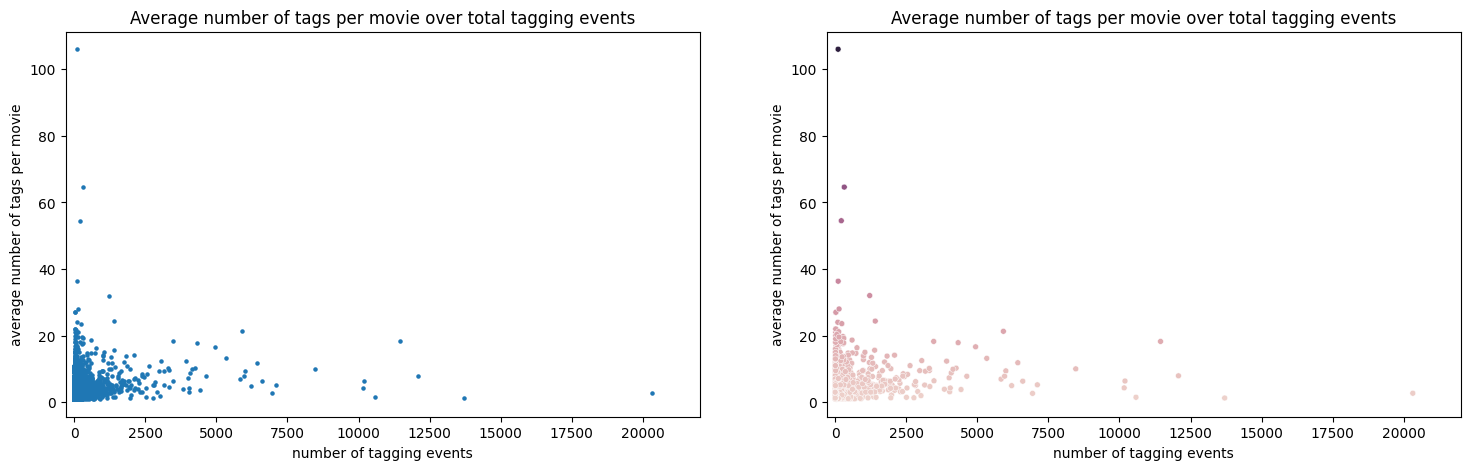

In [80]:
fig, ax = plt.subplots(figsize=(18, 5))
# remove axes and frame of subplot figure
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')
plt.subplots_adjust(hspace=0.5) # prevents overlapping of single plots

plt.subplot(121)
plt.scatter(x=user_tags_plt.n_tags_overall, y=user_tags_plt.n_tags_avg, s=5)
plt.xlim([-300,22000])
plt.title('Average number of tags per movie over total tagging events')
plt.xlabel('number of tagging events')
plt.ylabel('average number of tags per movie')
# plt.plot([0,6000],[5,5], c='r', alpha=0.6)

plt.subplot(122)
# sns.relplot(x=df_rat.n_ratings, y=df_rat.avg_rating) # relplot is not compatible with subplots!
sns.scatterplot(x=user_tags_plt.n_tags_overall, y=user_tags_plt.n_tags_avg, hue=user_tags_plt.n_tags_avg, size=10, legend=False)
plt.xlim([-300,22000])
plt.title('Average number of tags per movie over total tagging events')
plt.xlabel('number of tagging events')
plt.ylabel('average number of tags per movie');


<div class="alert alert-block alert-info"><b>Caution:</b> sns.relplot is not compatible with subplots!<br>
By limiting the x axis to 10,000 and the y axis to 22,000 two extreme outliers were excluded for better readability.</div>

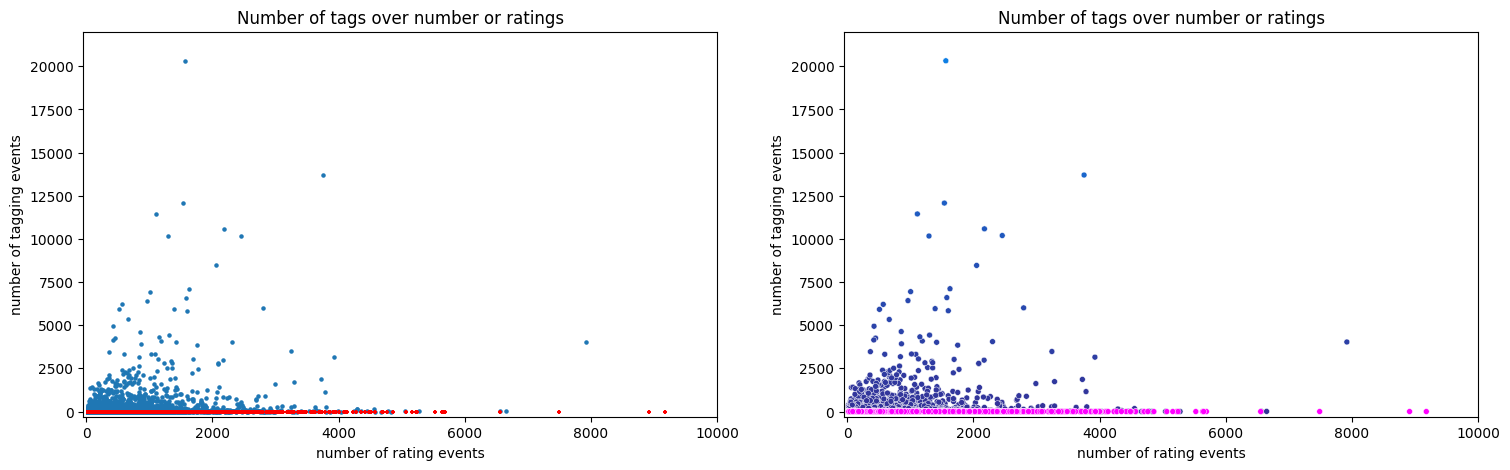

In [79]:
user_ratings_tags = user_ratings_tags.fillna(0)
fig, ax = plt.subplots(figsize=(18, 5))
# remove axes and frame of subplot figure
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')
plt.subplots_adjust(hspace=0.5) # prevents overlapping of single plots

plt.subplot(121)
# first plot all data point that do not contain NaNs (which were replaced with 0)
plt.scatter(x=user_ratings_tags.n_ratings.loc[user_ratings_tags['n_tags_overall'] != 0], 
            y=user_ratings_tags.n_tags_overall.loc[user_ratings_tags['n_tags_overall'] != 0], s=5)
# plot all n_tags_overall == 0 (former NaNs) in different color
plt.scatter(x=user_ratings_tags.n_ratings.loc[user_ratings_tags['n_tags_overall'] == 0], 
            y=user_ratings_tags.n_tags_overall.loc[user_ratings_tags['n_tags_overall'] == 0],marker='+', c  ='r', s=5)
plt.xlim([-50,10000])
plt.ylim([-300,22000])
plt.title('Number of tags over number or ratings')
plt.xlabel('number of rating events')
plt.ylabel('number of tagging events')
# plt.plot([0,6000],[5,5], c='r', alpha=0.6)

plt.subplot(122)
# sns.relplot(x=df_rat.n_ratings, y=df_rat.avg_rating) # relplot is not compatible with subplots!
# first plot all data point that do not contain NaNs (which were replaced with 0)
sns.scatterplot(x=user_ratings_tags.n_ratings.loc[user_ratings_tags['n_tags_overall'] != 0], 
                y=user_ratings_tags.n_tags_overall.loc[user_ratings_tags['n_tags_overall'] != 0], 
                hue=user_ratings_tags.n_tags_overall, size=10, legend=False, palette='terrain')
# plot all n_tags_overall == 0 (former NaNs) in different color
sns.scatterplot(x=user_ratings_tags.n_ratings.loc[user_ratings_tags['n_tags_overall'] == 0], 
                y=user_ratings_tags.n_tags_overall.loc[user_ratings_tags['n_tags_overall'] == 0], 
                hue=user_ratings_tags.n_tags_overall, size=10, legend=False, palette='spring')
plt.xlim([-50,10000])
plt.ylim([-300,22000])
plt.title('Number of tags over number or ratings')
plt.xlabel('number of rating events')
plt.ylabel('number of tagging events');

# even though there are many users who did not use a single tag, they do give ratings